# Calibrating single-qubit gates on Armonk

In this tutorial we demonstrate how to calibrate single-qubit gates on Armonk using the Calibration framework in qiskit-experiments. We will run experiments to find the qubit frequency, calibrate the amplitude of DRAG pulses and chose the value of the DRAG parameter that minimizes leakage. The calibration framework requires the user to

* setup an instance of `Calibrations` or `BackendCalibrations`,
* run calibration experiments which can be found either in `qiskit_experiments.library.calibration` or `qiskit_experiments.library.characterization`, and
* update the values of the parameters stored in the instance of `Calibrations` (or `BackendCalibrations`) using `Update` classes. 

You will see that the `Update` classes are not meant to be instantiated but provide an `update` class method to extract calibrated parameter values and add them to the calibrations.

In [1]:
import numpy as np

import qiskit.pulse as pulse
from qiskit.circuit import Parameter

from qiskit_experiments.calibration_management.backend_calibrations import BackendCalibrations

from qiskit import IBMQ, schedule

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [3]:
qubit = 0  # The qubit we will work with

The two functions below show how to setup an instance of `BackendCalibrations`. To do this the user defines the template schedules to calibrate. These template schedules are fully parameterized, even the channel indices on which the pulses are played. Furthermore, the name of the parameter in the channel index must follow the convention laid out in the documentation of the calibration module. Note that the parameters in the channel indices are automatically mapped to the channel index when `get_schedule` is called. 

In [4]:
def setup_cals(backend) -> BackendCalibrations:
    """A function to instantiate calibrations and add a couple of template schedules."""
    cals = BackendCalibrations(backend)

    dur = Parameter("dur")
    amp = Parameter("amp")
    sigma = Parameter("σ")
    beta = Parameter("β")
    drive = pulse.DriveChannel(Parameter("ch0"))

    # Define and add template schedules.
    with pulse.build(name="xp") as xp:
        pulse.play(pulse.Drag(dur, amp, sigma, beta), drive)

    with pulse.build(name="xm") as xm:
        pulse.play(pulse.Drag(dur, -amp, sigma, beta), drive)
        
    with pulse.build(name="x90p") as x90p:
        pulse.play(pulse.Drag(dur, Parameter("amp"), sigma, Parameter("β")), drive)

    cals.add_schedule(xp)
    cals.add_schedule(xm)
    cals.add_schedule(x90p)
    
    return cals

def add_parameter_guesses(cals: BackendCalibrations):
    """Add guesses for the parameter values to the calibrations."""
    for sched in ["xp", "x90p"]:
        cals.add_parameter_value(80, "σ", schedule=sched)
        cals.add_parameter_value(0.5, "β", schedule=sched)
        cals.add_parameter_value(320, "dur", schedule=sched)
        cals.add_parameter_value(0.5, "amp", schedule=sched)

When setting up the calibrations we add three pulses: a $\pi$-rotation, with a schedule named `xp`, a schedule `xm` identical to `xp` but with a nagative amplitude, and a $\pi/2$-rotation, with a schedule named `x90p`. Here, we have linked the amplitude of the `xp` and `xm` pulses. Therefore, calibrating the parameters of `xp` will also calibrate the parameters of `xm`.

In [5]:
cals = setup_cals(backend)
add_parameter_guesses(cals)

A samilar setup is achieved by using a pre-built library of gates. The library of gates provides a standard set of gates and some initial guesses for the value of the parameters in the template schedules. This is shown below using the `FixedFrequencyTransmon` which provides the `x`, `y`, `sx`, and `sy` pulses. Note that in the example below we change the default value of the pulse duration to 320 samples.

In [6]:
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon

In [7]:
library = FixedFrequencyTransmon(default_values={"duration": 320})
cals = BackendCalibrations(backend, library)

## 1. Finding qubits with spectroscopy

Here, we are using a backend for which we already know the qubit frequency. We will therefore use the spectroscopy experiment to confirm that there is a resonance at the qubit frequency reported by the backend.

In [8]:
from qiskit_experiments.library.characterization.qubit_spectroscopy import QubitSpectroscopy

We first show the contents of the calibrations for qubit 0. Note that the guess values that we added before apply to all qubits on the chip. We see this in the table below as an empty tuple `()` in the qubits column. Observe that the parameter values of `xm` do not appear in this table as they are given by the values of `xp`.

In [9]:
import pandas as pd

pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()]))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.000000e+00,2021-07-30 16:49:34.928455+0000,True,None,default,(),β,x
1,3.200000e+02,2021-07-30 16:49:34.928431+0000,True,None,default,(),duration,x
2,5.000000e-01,2021-07-30 16:49:34.928461+0000,True,None,default,(),amp,x
3,6.993371e+09,2021-07-30 16:49:34.928177+0000,True,None,default,"(0,)",meas_lo_freq,None
4,8.000000e+01,2021-07-30 16:49:34.928447+0000,True,None,default,(),σ,x
5,4.971648e+09,2021-07-30 16:49:34.928158+0000,True,None,default,"(0,)",qubit_lo_freq,None
6,0.000000e+00,2021-07-30 16:49:34.928466+0000,True,None,default,(),β,sx
7,3.200000e+02,2021-07-30 16:49:34.928472+0000,True,None,default,(),duration,sx
8,2.500000e-01,2021-07-30 16:49:34.928478+0000,True,None,default,(),amp,sx
9,8.000000e+01,2021-07-30 16:49:34.928484+0000,True,None,default,(),σ,sx


In [10]:
freq01_estimate = backend.defaults().qubit_freq_est[qubit]
frequencies = np.linspace(freq01_estimate -15e6, freq01_estimate + 15e6, 51)
spec = QubitSpectroscopy(qubit, frequencies)
spec.set_experiment_options(amp=0.1)

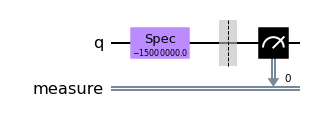

In [11]:
circuit = spec.circuits(backend)[0]
circuit.draw(output="mpl")

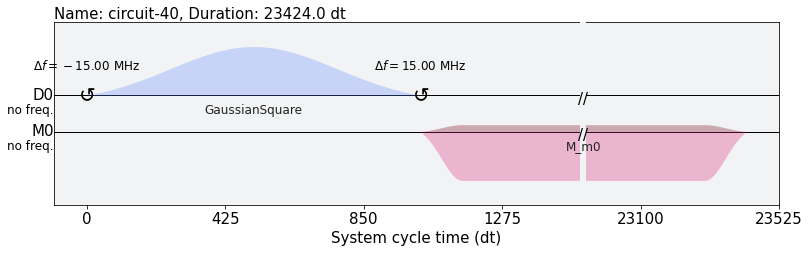

In [12]:
schedule(circuit, backend).draw()

In [13]:
spec_data = spec.run(backend)

In [14]:
spec_data.block_for_results()

ExperimentData(QubitSpectroscopy, 59577568-43a7-4a9e-9eb4-212c57c69b70, backend=ibmq_armonk, job_ids=['61042da633f22ee977fdec0b'])

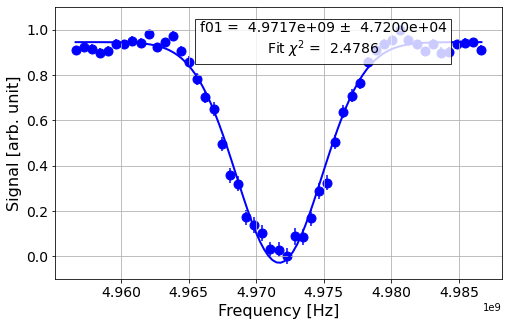

In [15]:
spec_data.figure(0)

In [16]:
print(spec_data.analysis_results("f01"))

DbAnalysisResultV1
- name: f01
- value: 4971702188.176047 ± 47199.74152748357 Hz
- χ²: 2.4785924412610782
- quality: good
- device_components: ['Q0']
- verified: False


We now update the instance of `Calibrations` with the value of the frequency that we measured using the `Frequency.update` function. Note that for the remainder of this notebook we use the value of the qubit frequency in the backend as it is not yet possible to updated qubit frequencies with the circuit path.

In [17]:
from qiskit_experiments.calibration_management.update_library import Frequency

Frequency.update(cals, spec_data)

In [18]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit]))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,6.993371e+09,2021-07-30 16:49:34.928177+0000,True,None,default,"(0,)",meas_lo_freq,None
1,4.971648e+09,2021-07-30 16:49:34.928158+0000,True,None,default,"(0,)",qubit_lo_freq,None
2,4.971702e+09,2021-07-31 01:50:47.798000+0900,True,59577568-43a7-4a9e-9eb4-212c57c69b70,default,"(0,)",qubit_lo_freq,None


As seen from the table above the measured frequency has been added to the calibrations.

## 2. Calibrating the pulse amplitudes with a Rabi experiment

In the Rabi experiment we apply a pulse at the frequency of the qubit and scan its amplitude to find the amplitude that creates a rotation of a desired angle.

In [19]:
from qiskit_experiments.library.calibration import Rabi
from qiskit_experiments.calibration_management.update_library import Amplitude

In [20]:
rabi = Rabi(qubit)
rabi.set_experiment_options(
    amplitudes=np.linspace(-0.95, 0.95, 51), 
    schedule=cals.get_schedule("x", (qubit,), assign_params={"amp": Parameter("amp")}),
)

In [21]:
rabi_data = rabi.run(backend)
rabi_data.block_for_results()

ExperimentData(Rabi, 727ec349-f498-4e99-9f4f-f5023a0a6247, backend=ibmq_armonk, job_ids=['61042def754b9d1b5b546016'])

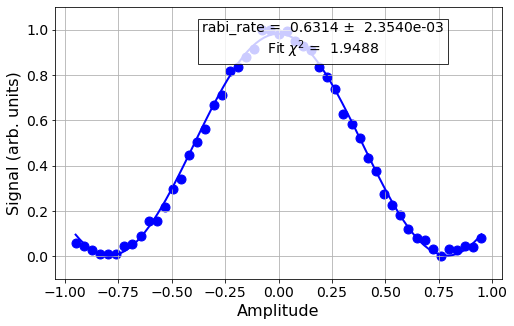

In [22]:
rabi_data.figure(0)

In [23]:
print(rabi_data.analysis_results("rabi_rate"))

DbAnalysisResultV1
- name: rabi_rate
- value: 0.6314380773548556 ± 0.002354041342852305
- χ²: 1.9488266962864866
- quality: good
- device_components: ['Q0']
- verified: False


In [24]:
Amplitude.update(cals, rabi_data, angles_schedules=[(np.pi, "amp", "x"), (np.pi/2, "amp", "sx")])

In [25]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.250000+0.000000j,2021-07-30 16:49:34.928478+0000,True,None,default,(),amp,sx
1,0.500000+0.000000j,2021-07-30 16:49:34.928461+0000,True,None,default,(),amp,x
2,0.791843+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,x
3,0.395922+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,sx


The table above shows that we have now updated the amplitude of our $\pi$-pulse from 0.5 to the value obtained in the most recent Rabi experiment. Importantly, since we linked the amplitudes of the `x` and `y` schedules we will see that the amplitude of the `y` schedule has also been updated as seen when requesting schedules form the `Calibrations` instance. Furthermore, we used the result from the `Rabi` experiment to also update the value of the `sx` pulse. This was achieved by specifying `(np.pi/2, "amp", "sx")` when calling `update`.

In [26]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.39592164+0j), sigma=80, beta=0), DriveChannel(0)), name="sx", transform=AlignLeft())

In [27]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.79184328+0j), sigma=80, beta=0), DriveChannel(0)), name="x", transform=AlignLeft())

In [28]:
cals.get_schedule("y", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=0.79184328j, sigma=80, beta=0), DriveChannel(0)), name="y", transform=AlignLeft())

## 3. Saving and loading calibrations

The values of the calibrated parameters can be saved to a `.csv` file and reloaded at a later point in time.  

In [29]:
cals.save(file_type="csv", overwrite=True, file_prefix="Armonk")

/home/knzwnao/qiskit/qiskit-experiments/qiskit_experiments/calibration_management/calibrations.py:937: UserWarning: Schedules are only saved in text format. They cannot be re-loaded.
  warnings.warn("Schedules are only saved in text format. They cannot be re-loaded.")


After saving the values of the parameters you may restart your kernel. If you do so, you will only need to run the following cell to recover the state of your calibrations. Since the schedules are currently not stored we need to call our `setup_cals` function to populate an instance of `Calibrations` with the template schedules. By contrast, the value of the parameters will be recovered from the file.

In [30]:
cals = BackendCalibrations(backend, library)
cals.load_parameter_values(file_name="Armonkparameter_values.csv")

In [31]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.250000+0.000000j,2021-07-30 16:52:03.091577+0000,True,None,default,(),amp,sx
1,0.250000+0.000000j,2021-07-30 16:49:34.928478+0000,True,,default,(),amp,sx
2,0.500000+0.000000j,2021-07-30 16:52:03.091515+0000,True,None,default,(),amp,x
3,0.500000+0.000000j,2021-07-30 16:49:34.928461+0000,True,,default,(),amp,x
4,0.791843+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,x
5,0.395922+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,sx


## 4. Calibrating the value of the DRAG coefficient

A Derivative Removal by Adiabatic Gate (DRAG) pulse is designed to minimize leakage
to a neighbouring transition. It is a standard pulse with an additional derivative
component. It is designed to reduce the frequency spectrum of a normal pulse near
the $|1\rangle$ - $|2\rangle$ transition, reducing the chance of leakage
to the $|2\rangle$ state. The optimal value of the DRAG parameter is chosen to
minimize both leakage and phase errors resulting from the AC Stark shift.
The pulse envelope is $f(t) = \Omega_x(t) + j \beta \frac{\rm d}{{\rm d }t} \Omega_x(t)$.
Here, $\Omega_x$ is the envelop of the in-phase component of the pulse and
$\beta$ is the strength of the quadrature which we refer to as the DRAG
parameter and seek to calibrate in this experiment. 
The DRAG calibration will run
several series of circuits. In a given circuit a Rp(β) - Rm(β) block is repeated
$N$ times. Here, Rp is a rotation with a positive angle and Rm is the same rotation
with a negative amplitude.

In [32]:
from qiskit_experiments.library.calibration.drag import DragCal
from qiskit_experiments.calibration_management.update_library import Drag

In [37]:
cal_drag = DragCal(qubit)

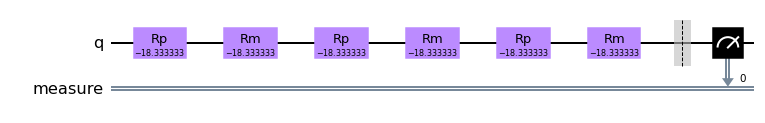

In [38]:
cal_drag.set_experiment_options(
    rp=cals.get_schedule("x", qubit, assign_params={"β": Parameter("β")}),
    betas=np.linspace(-20, 20, 25),
    reps=[3, 5, 7]
)

cal_drag.circuits(backend)[1].draw(output='mpl')

In [39]:
drag_data = cal_drag.run(backend)
drag_data.block_for_results()

ExperimentData(DragCal, b5a99e14-2886-482f-acfb-e59889f962a6, backend=ibmq_armonk, job_ids=['61042ee6ab246029efa3f6ae'])

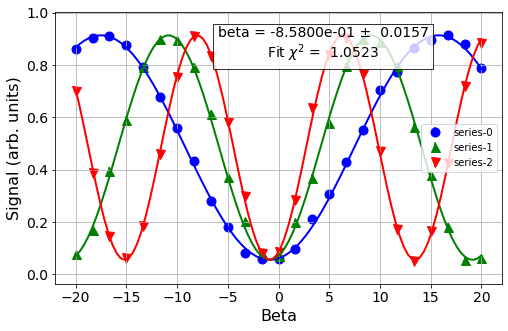

In [40]:
drag_data.figure(0)

In [41]:
print(drag_data.analysis_results("beta"))

DbAnalysisResultV1
- name: beta
- value: -0.8579999496516689 ± 0.01572960908346539
- χ²: 1.052265252338168
- quality: good
- device_components: ['Q0']
- verified: False


In [42]:
Drag.update(cals, drag_data, parameter="β", schedule="x")

In [43]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="β"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.000,2021-07-30 16:52:03.091495+0000,True,None,default,(),β,x
1,0.000,2021-07-30 16:49:34.928455+0000,True,,default,(),β,x
2,-0.858,2021-07-31 01:56:48.036000+0900,True,b5a99e14-2886-482f-acfb-e59889f962a6,default,"(0,)",β,x
3,0.000,2021-07-30 16:52:03.091537+0000,True,None,default,(),β,sx
4,0.000,2021-07-30 16:49:34.928466+0000,True,,default,(),β,sx


## 5. Fine amplitude calibration

The `FineAmplitude` calibration experiment repeats $N$ times a gate with a pulse
to amplify the under or over-rotations in the gate to determine the optimal amplitude.
The circuits that are run have a custom gate with the pulse schedule attached to it
through the calibrations.

In [44]:
from qiskit_experiments.library.calibration.fine_amplitude import FineXAmplitude
from qiskit_experiments.calibration_management.update_library import Amplitude

In [45]:
amp_x_cal = FineXAmplitude(qubit)
amp_x_cal.set_experiment_options(schedule=cals.get_schedule("x", qubit))

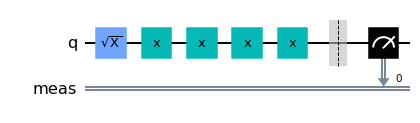

In [46]:
amp_x_cal.circuits(backend)[5].draw(output="mpl")

In [47]:
data_fine = amp_x_cal.run(backend)
data_fine.block_for_results()

ExperimentData(FineXAmplitude, cb30f831-da00-4373-bcd6-54c4a17776c2, backend=ibmq_armonk, job_ids=['61042f5c69320602a6185ac1'])

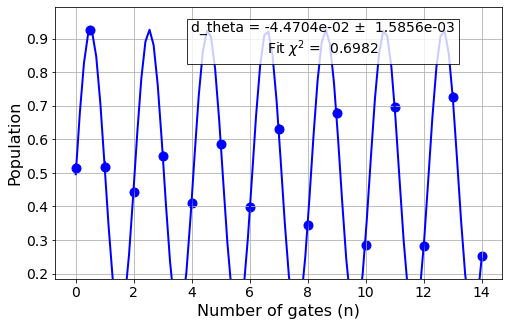

In [48]:
data_fine.figure(0)

In [49]:
print(data_fine.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.04470415398704396 ± 0.0015856159657519063
- χ²: 0.6981906224910402
- quality: good
- device_components: ['Q0']
- verified: False


The cell below shows how the amplitude is updated based on the error in the rotation angle measured by the `FineXAmplitude` experiment. Note that this calculation is automatically done by the `Amplitude.update` function.

In [50]:
dtheta = data_fine.analysis_results("d_theta").value.value
target_angle = np.pi
scale = target_angle / (target_angle + dtheta)
pulse_amp = cals.get_parameter_value("amp", qubit, "x")
print(f"The ideal angle is {target_angle:.2f} rad. We measured a deviation of {dtheta:.3f} rad.")
print(f"Thus, scale the {pulse_amp:.4f} pulse amplitude by {scale:.3f} to obtain {pulse_amp*scale:.5f}.")

The ideal angle is 3.14 rad. We measured a deviation of -0.045 rad.
Thus, scale the 0.7918+0.0000j pulse amplitude by 1.014 to obtain 0.80327+0.00000j.


In [51]:
Amplitude.update(cals, data_fine, angles_schedules=[(target_angle, "amp", "x")])

In [52]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.250000+0.000000j,2021-07-30 16:52:03.091577+0000,True,None,default,(),amp,sx
1,0.250000+0.000000j,2021-07-30 16:49:34.928478+0000,True,,default,(),amp,sx
2,0.500000+0.000000j,2021-07-30 16:52:03.091515+0000,True,None,default,(),amp,x
3,0.500000+0.000000j,2021-07-30 16:49:34.928461+0000,True,,default,(),amp,x
4,0.791843+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,x
5,0.803274+0.000000j,2021-07-31 01:57:30.497000+0900,True,cb30f831-da00-4373-bcd6-54c4a17776c2,default,"(0,)",amp,x
6,0.395922+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,sx


To check that we have managed to reduce the error in the rotation angle we will run the fine amplitude calibration experiment once again.

In [53]:
amp_x_cal.set_experiment_options(schedule=cals.get_schedule("x", qubit))

In [54]:
data_fine2 = amp_x_cal.run(backend)
data_fine2.block_for_results()

ExperimentData(FineXAmplitude, c6e0f829-e807-40a4-aa3e-82fb47e40ea0, backend=ibmq_armonk, job_ids=['61042f7f5c25cb3cc4d8379d'])

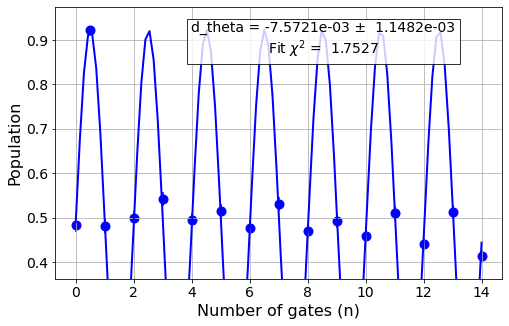

In [55]:
data_fine2.figure(0)

As can be seen from the data above and the analysis result below we have managed to reduce the error in the rotation angle ${\rm d}\theta$.

In [56]:
print(data_fine2.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.0075720612919127185 ± 0.0011482305771684511
- χ²: 1.7527416292071918
- quality: good
- device_components: ['Q0']
- verified: False


### Fine amplitude calibration of the $\pi/2$ rotation

We now wish to calibrate the amplitude of the $\pi/2$ rotation.

In [57]:
from qiskit_experiments.library.calibration.fine_amplitude import FineSXAmplitude

In [58]:
amp_sx_cal = FineSXAmplitude(qubit)
amp_sx_cal.set_experiment_options(schedule=cals.get_schedule("sx", qubit))

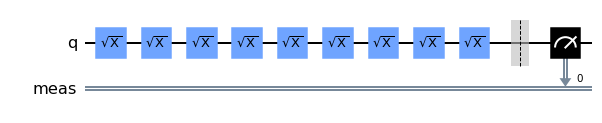

In [59]:
amp_sx_cal.circuits(backend)[5].draw(output="mpl")

In [60]:
data_fine_sx = amp_sx_cal.run(backend)
data_fine_sx.block_for_results()

ExperimentData(FineSXAmplitude, 30ace7b7-3117-4de3-9117-08a03653cc13, backend=ibmq_armonk, job_ids=['61042fa28e24426019b086c5'])

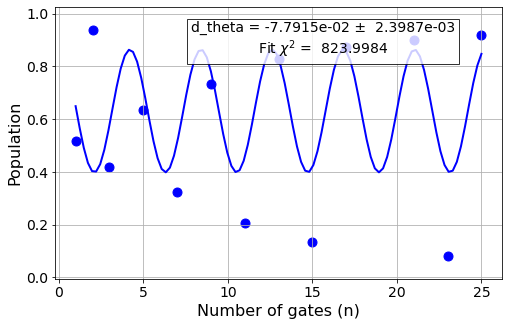

In [61]:
data_fine_sx.figure(0)

In [62]:
print(data_fine_sx.analysis_results("d_theta"))

DbAnalysisResultV1
- name: d_theta
- value: -0.07791511801979653 ± 0.0023986700260456907
- χ²: 823.9984404446161
- quality: bad
- device_components: ['Q0']
- verified: False


In [63]:
Amplitude.update(cals, data_fine_sx, angles_schedules=[(np.pi/2, "amp", "sx")])

In [64]:
pd.DataFrame(cals.parameters_table(qubit_list=[qubit, ()], parameters="amp"))

,value,date_time,valid,exp_id,group,qubits,parameter,schedule
0,0.250000+0.000000j,2021-07-30 16:52:03.091577+0000,True,None,default,(),amp,sx
1,0.250000+0.000000j,2021-07-30 16:49:34.928478+0000,True,,default,(),amp,sx
2,0.500000+0.000000j,2021-07-30 16:52:03.091515+0000,True,None,default,(),amp,x
3,0.500000+0.000000j,2021-07-30 16:49:34.928461+0000,True,,default,(),amp,x
4,0.791843+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,x
5,0.803274+0.000000j,2021-07-31 01:57:30.497000+0900,True,cb30f831-da00-4373-bcd6-54c4a17776c2,default,"(0,)",amp,x
6,0.395922+0.000000j,2021-07-31 01:51:59.054000+0900,True,727ec349-f498-4e99-9f4f-f5023a0a6247,default,"(0,)",amp,sx
7,0.416585+0.000000j,2021-07-31 01:58:36.081000+0900,True,30ace7b7-3117-4de3-9117-08a03653cc13,default,"(0,)",amp,sx


In [65]:
cals.get_schedule("sx", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.416585227381143+0j), sigma=80, beta=0), DriveChannel(0)), name="sx", transform=AlignLeft())

In [66]:
cals.get_schedule("x", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=(0.803273683105332+0j), sigma=80, beta=-0.857999949651669), DriveChannel(0)), name="x", transform=AlignLeft())

In [67]:
cals.get_schedule("y", qubit)

ScheduleBlock(Play(Drag(duration=320, amp=0.803273683105332j, sigma=80, beta=-0.857999949651669), DriveChannel(0)), name="y", transform=AlignLeft())

In [68]:
import qiskit.tools.jupyter
%qiskit_copyright